<a href="https://colab.research.google.com/github/devdastl/-EVA-8_Phase-1_Assignment-4/blob/main/step_3/EVA_assignment_4_step3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Third code version setup in building the Neural Network
## **Target**
Following are the targets for third code setup.
1. Reduce the model overfitting.
2. Introduce "Drop Out" in CNN model. This will also helps with overfitting by randomly killing neurons in a layer while training the model and forcing other layers neuron not to focus on single neuron everytime.
3. Use image transformation to augment training images. Image Augmentation helps to reduce overfitting by forcing model to fit more images so that any kind of bias is ruled output. 

Example of augmentation: If training image has object in certain orientation and in test image orientation might be different then model will not perfrom well on that test image. Hence rotation transformation can augment this on training image.
Since handwrittern digits can have different orientation (also same is reflected in 7th block of first setup) we will use rotation transformation in our training set.

## **Result**
Below are the results of third code setup.
1. Total number of parameters - `9,930 (<10k)`
1. Training accuracy at 15th epoch - `98.77%`
1. Testing accuracy at 15th epoch - `99.16%`
1. Training accuracy at 20th epoch - `98.84%`
1. Testing accuracy at 20th epoch - `99.26%` 

## **Analysis**
Following are the analysis of this third code setup:
1. Model is now **underfitting** i.e. testing accuracy is larger then training accuracy.
2. Due to larger underfitting accuracy dropped for both training and testing dataset. Not good for the model performance.
3. Due to "Drop Out" model could be suffering from excessive regularization which migh have impacted overall perfromance of the model as well as underfitting.
4. Accuracy is also fluctuating alot due to fluctuation in loss in later epochs. Maybe changing the learning rate in step can help to smooth out the decent.

## Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations
NOTE: Here we are adding rotation based image augmentation to increase the dataset size and to reduce unnecessary linear transformation(rotation) related bias. 
- First transform perform image augmentation by imparting rotation to the image.
- second transform convert dataset into pytorch tensor.
- third transform will normalize the image by using mean and standerd deviation of complete dataset. We can use numpy to calculate this values as shown in cell 5.

output of cell 5 after commenting `transforms.Normalize` transformation.
```
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - "mean: tensor(0.1307)"
 - "std: tensor(0.3081)"
 - var: tensor(0.0949)
torch.Size([128, 1, 28, 28])
torch.Size([128])
```
As shown above it gives values 0.1307 as mean and 0.3081 as standerd deviation.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)), #adding rotation based image augmentation
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


## Dataset and Creating Train/Test Split
Here we are creating pytorch dataset set class for train and test set.

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## GPU and data loader setup
In below cell first we are checking if cuda devices(GPU) are available as well as we are setting up data loader for train and test set which will create batches of the set for training.

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model architecture
Here the CNN model just uses convolution, pooling and activation. One focus while building this architecture is to keep the parameters under 10k.
Model architecture is also shown in the github README.

**NOTE**: Introducing `nn.Dropout()` in each layer to solve overfitting. 

In [5]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
      # First block of CNN--------------
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 11

        # Second block of CNN---------------
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 9

        # Third block of CNN---------------
        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        # Forth block of CNN---------------
        self.layer7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 5
        self.layer8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1x1x10 



    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool1(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        x=self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model visualization
Here we are using external tool `torchsummary` to visualize our model architecture as well as the number of paramters (which are under 10k).

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 14, 24, 24]           1,260
       BatchNorm2d-6           [-1, 14, 24, 24]              28
              ReLU-7           [-1, 14, 24, 24]               0
           Dropout-8           [-1, 14, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,016
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0

# Training and Testing

In this cell we have writtern training and testing loop which will go through each batch of loader and will perfrom a forward pass and then gradient calcuation.

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Model training
Here we will loop through epoch and call our train and test functions which we have already defined.

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.24674218893051147 Batch_id=468 Accuracy=82.11: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]



Test set: Average loss: 0.1167, Accuracy: 9725/10000 (97.25%)

EPOCH: 1


Loss=0.06776798516511917 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:18<00:00, 25.36it/s]



Test set: Average loss: 0.0510, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.04676487669348717 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]



Test set: Average loss: 0.0409, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.07181592285633087 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]



Test set: Average loss: 0.0436, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.08034083992242813 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:19<00:00, 23.92it/s]



Test set: Average loss: 0.0354, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Loss=0.02530941180884838 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:18<00:00, 24.83it/s]



Test set: Average loss: 0.0300, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.060599107295274734 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:18<00:00, 24.98it/s]



Test set: Average loss: 0.0306, Accuracy: 9901/10000 (99.01%)

EPOCH: 7


Loss=0.13057613372802734 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:19<00:00, 24.48it/s]



Test set: Average loss: 0.0253, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.0352407768368721 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]



Test set: Average loss: 0.0273, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.020393455401062965 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:19<00:00, 24.50it/s]



Test set: Average loss: 0.0307, Accuracy: 9901/10000 (99.01%)

EPOCH: 10


Loss=0.09820766001939774 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:19<00:00, 23.80it/s]



Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

EPOCH: 11


Loss=0.06369291990995407 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]



Test set: Average loss: 0.0340, Accuracy: 9892/10000 (98.92%)

EPOCH: 12


Loss=0.05121438205242157 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:19<00:00, 24.13it/s]



Test set: Average loss: 0.0325, Accuracy: 9901/10000 (99.01%)

EPOCH: 13


Loss=0.04644813761115074 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:19<00:00, 23.84it/s]



Test set: Average loss: 0.0253, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.02135823853313923 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:19<00:00, 24.14it/s]



Test set: Average loss: 0.0283, Accuracy: 9914/10000 (99.14%)

EPOCH: 15


Loss=0.06275523453950882 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:19<00:00, 24.11it/s]



Test set: Average loss: 0.0276, Accuracy: 9916/10000 (99.16%)

EPOCH: 16


Loss=0.06856027990579605 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:19<00:00, 24.35it/s]



Test set: Average loss: 0.0265, Accuracy: 9913/10000 (99.13%)

EPOCH: 17


Loss=0.024439344182610512 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:19<00:00, 24.23it/s]



Test set: Average loss: 0.0260, Accuracy: 9917/10000 (99.17%)

EPOCH: 18


Loss=0.036073729395866394 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:19<00:00, 24.26it/s]



Test set: Average loss: 0.0246, Accuracy: 9927/10000 (99.27%)

EPOCH: 19


Loss=0.04856028035283089 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:19<00:00, 24.40it/s]



Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)



## Result visualization
Here we will visualize or plot graphs for train and test loss and accuracy with respect to the number of iteration. (1 iteration = pass from 1 batch)

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
train_loss_list = np.array([num.item() for num in train_losses ])


Text(0.5, 1.0, 'Test Accuracy')

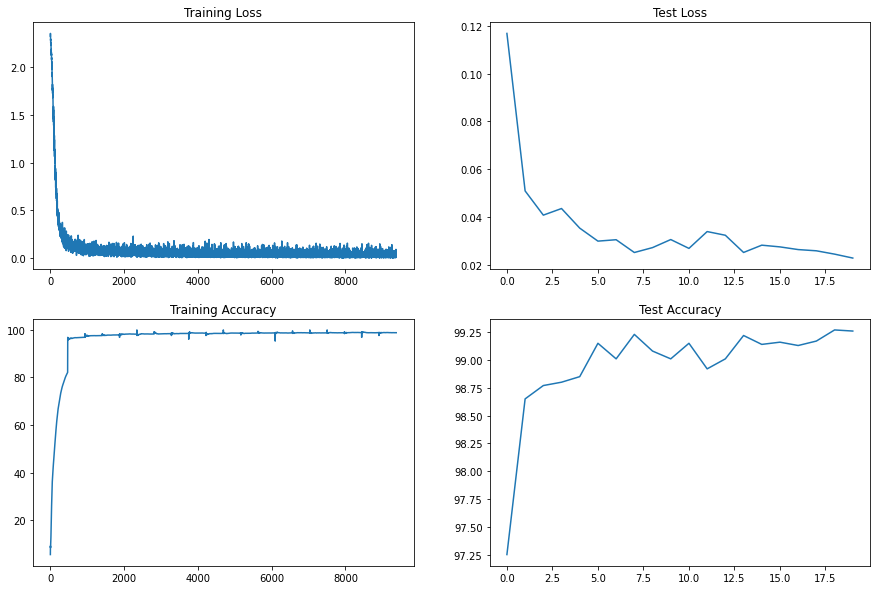

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_list)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")